# Can we build an ensemble model to help us make a profit? Should this model use a running window or is the nature of gold prices static? These are some of the many questions that we will hope to answer.
## Table of Contents

In [91]:
import pandas as pd 
import numpy as np
#Regular expressions for fine-tuned searching
import matplotlib.pyplot as plt
import re
import datetime

In [156]:
df = pd.read_csv("financial_regression.csv")

Let's take a look at our dataset:

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

In [115]:
df.head(3)

,date,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,...,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold open,gold high,gold low,gold close,gold volume
0,2010-01-14,114.49,115.14,114.42,114.93,115646960.0,0.72,46.26,46.52,46.22,...,45.02,43.86,44.84,364528.0,1.16,111.51,112.37,110.79,112.03,18305238.0
1,2010-01-15,114.73,114.84,113.20,113.64,212252769.0,1.64,46.46,46.55,45.65,...,45.76,44.40,45.76,442210.0,1.36,111.35,112.01,110.38,110.86,18000724.0
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### As you can see, the close price of an index on one day does not equal the open price of the same index on the following day. In order to account for the change in price after trading hours, we will look at the log returns of the close/open prices only. We will choose to use log returns of closing prices, a running standard deviation value of the same day volume, and the percent difference of high/low. This will allow us to keep as many variables as possible. We will however need to determine if we will be overfitting due to high variable count.
#### Let us determine first how much cleaning we will have to do first.

In [157]:
#Drop the open prices
df = df.drop([col for col in df.columns if 'open' in col], axis=1)

In [158]:
df.head(4)

,date,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq high,nasdaq low,nasdaq close,nasdaq volume,...,platinum high-low,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold high,gold low,gold close,gold volume
0,2010-01-14,115.14,114.42,114.93,115646960.0,0.72,46.52,46.22,46.39,75209000.0,...,2.1300,45.02,43.86,44.84,364528.0,1.16,112.37,110.79,112.03,18305238.0
1,2010-01-15,114.84,113.20,113.64,212252769.0,1.64,46.55,45.65,45.85,126849300.0,...,1.7500,45.76,44.40,45.76,442210.0,1.36,112.01,110.38,110.86,18000724.0
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-19,115.13,113.59,115.06,138671890.0,1.54,46.64,45.95,46.59,84388200.0,...,3.0278,47.08,45.70,46.94,629150.0,1.38,111.75,110.83,111.52,10467927.0


#### The high - low columns do not reflect change relative to stock price. A better alternative is to use percent difference.

In [159]:
#Let's attain the list of unique asssets that have closing price. This will exclude GDP, etc. that does not have low/high.
unique_assets = [re.findall(r"^(.*?)(?=\sclose)", c)[0] for c in df.columns if "close" in c]
print(unique_assets)

['sp500', 'nasdaq', 'silver', 'oil', 'platinum', 'palladium', 'gold']


In [160]:
df_temp = df.copy()

In [161]:
#For each asset that has low/high: create a column that represents the division of high/low for same day:
for a in unique_assets:
    df.loc[:,f"{a} high/low"] = df.loc[:, f"{a} high"]/df.loc[:,f"{a} low"]

In [162]:
df.head(3)

,date,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq high,nasdaq low,nasdaq close,nasdaq volume,...,gold low,gold close,gold volume,sp500 high/low,nasdaq high/low,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low
0,2010-01-14,115.14,114.42,114.93,115646960.0,0.72,46.52,46.22,46.39,75209000.0,...,110.79,112.03,18305238.0,1.006293,1.006491,1.013550,1.014403,1.013336,1.026448,1.014261
1,2010-01-15,114.84,113.20,113.64,212252769.0,1.64,46.55,45.65,45.85,126849300.0,...,110.38,110.86,18000724.0,1.014488,1.019715,1.009804,1.019331,1.010972,1.030631,1.014767
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we can drop the low/high columns, as that information is already represented in the division columns

In [173]:
df = df.drop([col for col in df.columns if re.match(r"(.*\s(high|low|high-low)$)", col)], axis=1)

### Our new dataset looks like so:

In [174]:
df.head(3)

,date,sp500 close,sp500 volume,nasdaq close,nasdaq volume,us_rates_%,CPI,usd_chf,eur_usd,GDP,...,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low,us_rates_%_interpolated,CPI_interpolated,usd_chf_interpolated,eur_usd_interpolated,GDP_interpolated
0,2010-01-14,114.93,115646960.0,46.39,75209000.0,NaN,NaN,1.0206,1.4478,NaN,...,1.013550,1.014403,1.013336,1.026448,1.014261,0.13,217.281,1.0206,1.44780,14980.193
1,2010-01-15,113.64,212252769.0,45.85,126849300.0,NaN,NaN,1.0264,1.4376,NaN,...,1.009804,1.019331,1.010972,1.030631,1.014767,0.13,217.281,1.0264,1.43760,14980.193
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.13,217.281,1.0302,1.43225,14980.193


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 close         3719 non-null   float64
 2   sp500 volume        3719 non-null   float64
 3   nasdaq close        3719 non-null   float64
 4   nasdaq volume       3719 non-null   float64
 5   us_rates_%          176 non-null    float64
 6   CPI                 176 non-null    float64
 7   usd_chf             3694 non-null   float64
 8   eur_usd             3694 non-null   float64
 9   GDP                 57 non-null     float64
 10  silver close        3719 non-null   float64
 11  silver volume       3719 non-null   float64
 12  oil close           3719 non-null   float64
 13  oil volume          3719 non-null   float64
 14  platinum close      3719 non-null   float64
 15  platinum volume     3719 non-null   float64
 16  pallad

In [166]:
non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
print(non_asset_columns)

['date', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP']


Now let's update the date column to be type 'datetime'

In [167]:
df['date'] =df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

As we can see, rates, CPI, and GDP are mostly nulls. What can we do about these to keep some of the info intact?

In [171]:
df[non_asset_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3904 non-null   datetime64[ns]
 1   us_rates_%  176 non-null    float64       
 2   CPI         176 non-null    float64       
 3   usd_chf     3694 non-null   float64       
 4   eur_usd     3694 non-null   float64       
 5   GDP         57 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 183.1 KB


In [169]:
df[non_asset_columns].query("GDP.notnull()").head(4)

,date,us_rates_%,CPI,usd_chf,eur_usd,GDP
55,2010-04-01,0.20,217.403,1.0559,1.3569,14980.193
121,2010-07-01,0.18,217.605,1.0675,1.2464,15141.607
188,2010-10-01,0.19,219.035,0.9761,1.3754,15309.474
254,2011-01-01,0.17,221.187,NaN,NaN,15351.448


As one can see, GDP is updated once every three months. Let's assume a constant growth rate between each measurement.

In [179]:
df = df_temp.copy()

In [136]:
df_temp = df.copy()

Interpolate forwards then backwards to get initial rows

In [178]:
"""non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]
df[[col+"_interpolated" for col in non_asset_date_columns]] =df[non_asset_date_columns].interpolate()
df[[col for col in df.columns if "interpolated" in col]] = df[[col for col in df.columns if "interpolated" in col]].interpolate(limit_direction="backward")"""

'non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]\ndf[[col+"_interpolated" for col in non_asset_date_columns]] =df[non_asset_date_columns].interpolate()\ndf[[col for col in df.columns if "interpolated" in col]] = df[[col for col in df.columns if "interpolated" in col]].interpolate(limit_direction="backward")'

We can also have columns representing CPI, usd_chf, eur_usd of latest available data. This will look reminiscent to a square wave (_ - _) and will allow us to calculate percent differences

Let's bring forward all known non-asset values to fill NULLs.

In [188]:
non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]
df[non_asset_columns] = df[non_asset_columns].ffill()

It's best to keep information regarding the difference in non_asset data such as CPI relative to when it was first available. We will call this "shock"

In [197]:
df[[col+"_shock" for col in non_asset_date_columns]] = df[non_asset_date_columns]/df[non_asset_date_columns].shift(1)

Also note that there is one currency relationship that is USD over CHF, and another where it is the divisor (EUR). Let's make it inverse.

In [227]:
df['usd_eur'] = 1/df['eur_usd']

Note that inflation affects both GDP, CPI, and S&P. Let's look at the relationship between the S&P and various non asset values such as CPI. 

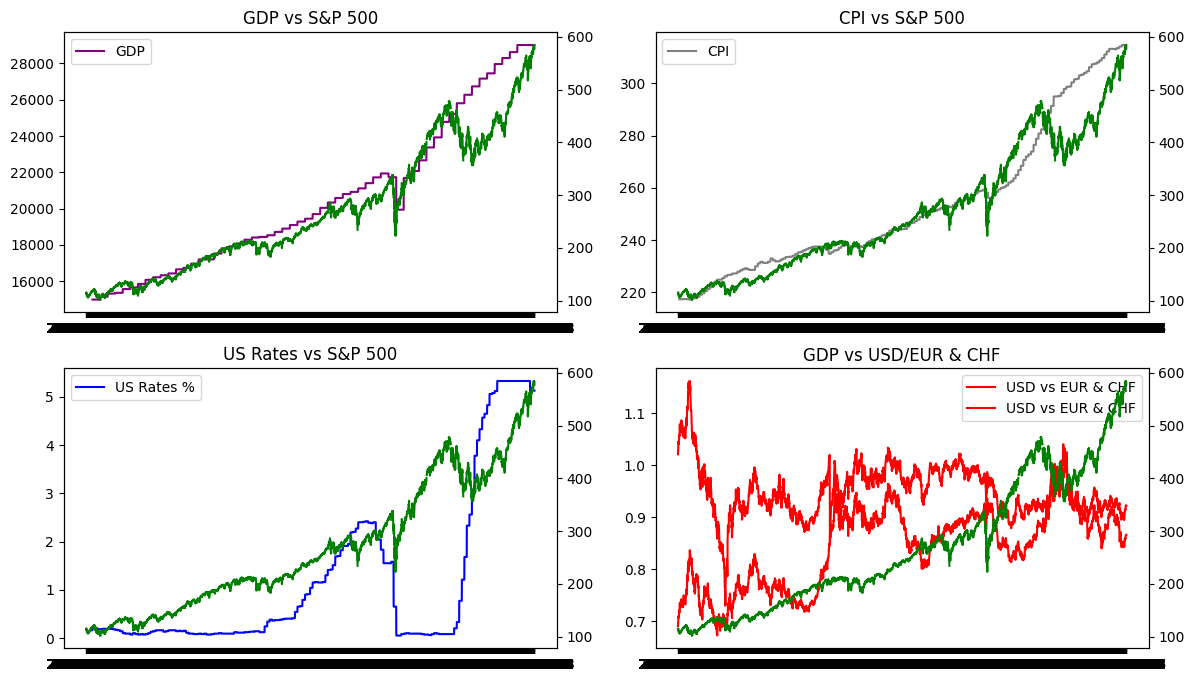

In [228]:
fig, axs = plt.subplots(2,2, figsize=(14,8))
#GDP
axs[0,0].plot(df.date, df.GDP, label="GDP", color="purple")
ax
axs[0,0].set_title("GDP vs S&P 500")
axs[0,0].legend()

axs_spy = axs[0,0].twinx()
axs_spy.plot(df.date, df["sp500 close"], label="S&P 500", color='g')
#axs_spy.legend()



#US Rates
axs[1,0].plot(df.date, df["us_rates_%"], label="US Rates %", color="blue")
ax
axs[1,0].set_title("US Rates vs S&P 500")
axs[1,0].legend()

axs_spy = axs[1,0].twinx()
axs_spy.plot(df.date, df["sp500 close"], label="S&P 500", color='g')
#axs_spy.legend()

#CPI
axs[0,1].plot(df.date, df["CPI"], label="CPI", color="grey")
ax
axs[0,1].set_title("CPI vs S&P 500")
axs[0,1].legend()

axs_spy = axs[0,1].twinx()
axs_spy.plot(df.date, df["sp500 close"], label="S&P 500", color='g')
#axs_spy.legend()

#CPI
axs[1,1].plot(df.date, df[['usd_chf', 'usd_eur']], label="USD vs EUR & CHF", color="red")
ax
axs[1,1].set_title("GDP vs USD/EUR & CHF")
axs[1,1].legend()

axs_spy = axs[1,1].twinx()
axs_spy.plot(df.date, df["sp500 close"], label="S&P 500", color='g')
#axs_spy.legend()

plt.show()
#plt.plot(df['date'], df[[col for col in non_asset_columns if col!='date']])

In [212]:
df.columns

Index(['date', 'sp500 high', 'sp500 low', 'sp500 close', 'sp500 volume',
       'sp500 high-low', 'nasdaq high', 'nasdaq low', 'nasdaq close',
       'nasdaq volume', 'nasdaq high-low', 'us_rates_%', 'CPI', 'usd_chf',
       'eur_usd', 'GDP', 'silver high', 'silver low', 'silver close',
       'silver volume', 'silver high-low', 'oil high', 'oil low', 'oil close',
       'oil volume', 'oil high-low', 'platinum high', 'platinum low',
       'platinum close', 'platinum volume', 'platinum high-low',
       'palladium high', 'palladium low', 'palladium close',
       'palladium volume', 'palladium high-low', 'gold high', 'gold low',
       'gold close', 'gold volume', 'us_rates_%_shock', 'CPI_shock',
       'usd_chf_shock', 'eur_usd_shock', 'GDP_shock'],
      dtype='object')

Let's drop rows where the markets were closed

In [107]:
df = df.dropna(subset=[x for x in df.columns if x not in non_asset_columns])
df.shape

(3719, 27)

In [100]:
df.CPI.describe()

count    176.000000
mean     253.275511
std       27.444318
min      217.199000
25%      233.637750
50%      244.178000
75%      262.784250
max      314.686000
Name: CPI, dtype: float64